In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('D:\\6OHDA\\')
#import mpld3
#mpld3.enable_notebook()
import numpy as np
import scipy as sci
from scipy import signal
from matplotlib import pyplot as plt
from matplotlib import gridspec
import matplotlib.colors as Mcolors
import matplotlib.cm as cmx
import sys
import h5py
from IO import *
from utils import *
from plotUtils import *
from ColorSchems import colorPallet as CP
import pptx
from pptx import Presentation 
from pptx.util import Inches
from io import BytesIO
import re
import warnings
import pandas as pd
import sqlalchemy as db
import gc
from tqdm import tqdm
import seaborn as sns
import pywt # wavelet package
import statsmodels.api as sm
import sklearn as sk

In [3]:
Files = ['FinalData_6OHDA.h5','FinalData_6OHDA_H.h5']
miceList = getMiceList(Files[0])

In [4]:
def periodCalc(day):
    if day== 0:
        return 'Healthy'
    elif day<13:
        return 'Acute' #day 1-13
    else:
        return 'Chronic' #day 14-35

In [5]:
def packData(data,names):
    # takes numpy array and turn to data frame for GLM training
    # Input: 
    #    data - numpy array, each column in a variable
    #    names - list of strings with column names 
    # Output:
    #    df - pandas df that has an intercept column (all 1), 
    #         and a column for each of the variables in data
    
    row,col = data.shape
    if len(names)!= col:
        if len(names) == row:
            warnings.warn("length of names don't match number of columns, data transposed")
            data = data.T
            row,col = data.shape
        else:
            raise ValueError("length of names do not match data. len names = ",len(names),", data.shape =",data.shape)
    
    df = pd.DataFrame(data=data, columns=names)
    df["Intercept"] = np.ones(row)
    return df
            

In [47]:
%matplotlib inline
from statsmodels.genmod.families import Poisson, Gamma, Gaussian

def trainModelSm(predictors,y,k=1,plot=True,family=Gamma(link=sm.families.links.log)):
    if k<1:
        k = 1
    # no cross validation, use all data as train and return train AIC
    if k == 1: 
        model = sm.GLM(y, predictors, family=family)
        model_results = model.fit()
        b = model_results.params
#         print(model_results.summary())
        aic = model_results.aic
        y_hut = np.exp(np.sum(b*predictors,axis=1)) 
        # plot if required
        if plot: 
            fig, (ax,ax2) = plt.subplots(2,1,figsize=(10,6))
            ax.plot(y,label='y',color='k')
            ax.plot(y_hut,label='y^',color='g')
            ax2.scatter(y,y_hut,alpha=0.5)
            ax2.set_xlabel('y')
            ax2.set_ylabel('y^')
            ax.set_title("train aic = {0:8.2f}".format(model_results.aic)) 
            ax.legend()
        return aic,model_results,b
    # cross validation,return all models
    else:
        batchSize = np.floor(len(predictors)/k)
        aic = []
        results = {}
        if plot:
            fig, ax = plt.subplots(k,1,figsize=(10,6))
        for itr in range(k):
            # divide data into train and test
            testInds = predictors.index.isin(np.arange(itr*batchSize,(itr+1)*batchSize))
            trainData = predictors[~testInds]
            trainY = y[~testInds]
            testData = predictors[testInds]
            testY = y[testInds]
            # train the model
            model = sm.GLM(trainY, trainData, family=family)
            model_results = model.fit()
            b = model_results.params
            aic.append(model_results.aic)
            results[str(itr)] = model_results
            y_hut = np.exp(np.sum(b*testData,axis=1))
            if plot:
                ax[itr].plot(np.arange(0,np.max(testY.shape)),testY,label='y',color='k')
                ax[itr].plot(np.arange(0,np.max(testY.shape)),y_hut,label='y^',color='g')
                ax[itr].set_title("test r = {0:8.4f}".format(sci.stats.pearsonr(testY,y_hut)[0]))
            fig.tight_layout()
        bestFit = np.argmax(aic)
#         if plot:
#             sns.displot(aic,kde=True)
        print(results[str(bestFit)].summary())
        return aic,results,1
            
            



<ipython-input-47-944b39c26244>:4: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  def trainModelSm(predictors,y,k=1,plot=True,family=Gamma(link=sm.families.links.log)):


In [7]:
from statsmodels import graphics
def compareNested(model1,model2):
    dev1 = model1.deviance 
    dev2 = model2.deviance 
    p = 1 - sci.stats.chi2.cdf(dev1 - dev2, len(model1.params)-len(model2.params)) 
    print('p:', p)
    return p
def residualPlot(model,predictors,fs=20,res = 'Person'):
    fig, (ax,ax2) = plt.subplots(2,1)
    resType = {'Person':model.resid_pearson,
               'Raw':model.resid_response}
    R = np.cumsum(resType[res])
    t = np.arange(len(R))/fs
    ax.plot(t,R)
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Cumulative Residuals')
    b = model.params
    y_hut = np.exp(np.sum(b*predictors,axis=1)) 
    ax2.scatter(y_hut, resType[res],alpha=0.3)
    ax2.hlines(0, 0, np.Inf)
    ax2.set_title('Residual Dependence Plot')
    ax2.set_ylabel(res+' Residuals')
    ax2.set_xlabel('y^')
    
    resid = model.resid_deviance.copy()
    graphics.gofplots.qqplot(resid, line='r')



In [53]:
maxSpeed = 35.76553174529567
m = '1208'
sess = m + '_BaselineA'
data = getData(Files[1],['speed'],period ='Pre', mice=m, day = lambda x: x==0)


ca = np.nanmean(getOnsetOrPeriod(m,sess,'Pre','caOnset_Hf'),axis=0,keepdims=True)
speed = data[sess]['speed']['speed']
speed = speed/maxSpeed
speed[speed>1] = 1

df = packData(speed,["speed"])
df

cleaning up speed data


D:\6OHDA\IO.py:152: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  speed = hf[m][s]['mvmt']['speed'].value
D:\6OHDA\IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value
<ipython-input-5-bcaa56cb2ae5>:13: UserWarning: length of names don't match number of columns, data transposed
  warnings.warn("length of names don't match number of columns, data transposed")


,speed,Intercept
0,0.015580,1.0
1,0.017062,1.0
2,0.027610,1.0
3,0.040014,1.0
4,0.079644,1.0
...,...,...
11894,0.703338,1.0
11895,0.517604,1.0
11896,0.524506,1.0
11897,0.527625,1.0


C:\Users\dzemel\Miniconda3\lib\site-packages\statsmodels\genmod\families\family.py:735: RuntimeWarning: divide by zero encountered in log
  ll_obs -= special.gammaln(weight_scale) + np.log(endog)
C:\Users\dzemel\Miniconda3\lib\site-packages\statsmodels\genmod\families\family.py:735: RuntimeWarning: divide by zero encountered in log
  ll_obs -= special.gammaln(weight_scale) + np.log(endog)
C:\Users\dzemel\Miniconda3\lib\site-packages\statsmodels\genmod\families\family.py:735: RuntimeWarning: divide by zero encountered in log
  ll_obs -= special.gammaln(weight_scale) + np.log(endog)


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 7933
Model:                            GLM   Df Residuals:                     7931
Model Family:                   Gamma   Df Model:                            1
Link Function:                    log   Scale:                         0.89486
Method:                          IRLS   Log-Likelihood:                    inf
Date:                Wed, 06 Oct 2021   Deviance:                       53259.
Time:                        16:37:39   Pearson chi2:                 7.10e+03
No. Iterations:                    20                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
speed          1.4082      0.067     21.068      0.0

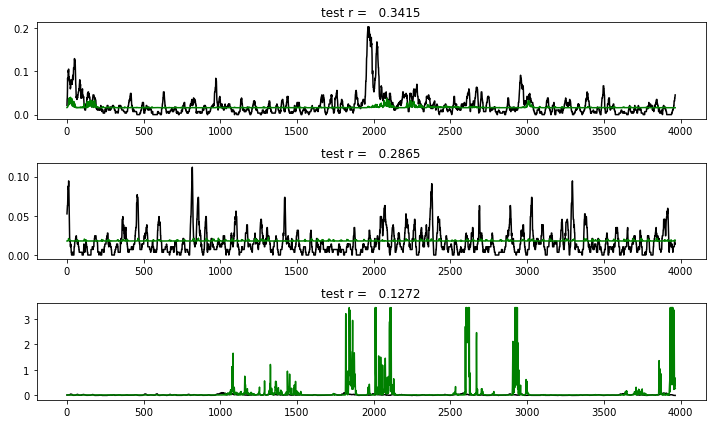

In [54]:
aic,model_results,b =trainModelSm(df,ca[0,:len(df)],k=3)
# y_hut = np.exp(np.sum(model_results['2'].params*df,axis=1)) 
# y = df.speed.values
# sci.stats.pearsonr(y,y_hut)
# print(dff[0,:].shape,len(df))
# b

<h2> method #1: directly model neuron -> speed and compare residuals </h2>

In [9]:
# use random 100 neurons for each session. 
# train on first half of trace, test on secound half
# save resedials of both. 
for m in miceList:
    data = getData(Files[1],['trace','speed'],period ='Pre', mice=m)
    testRes = {'Healthy':{'bins':[],'weights':[]},'Acute':{'bins':[],'weights':[]},'Chronic':{'bins':[],'weights':[]}}
    trainRes = {'Healthy':{'bins':[],'weights':[]},'Acute':{'bins':[],'weights':[]},'Chronic':{'bins':[],'weights':[]}}
    binwidth = 1
    for sess in tqdm(data.keys()):
        if sess[5] == 'B':
            day = 0
        else:
            day = int(re.findall(r'\d+',sess[5:])[0])
        period = periodCalc(day)
        speed = data[sess]['speed']['speed']
        nNeurons = data[sess]['trace']['dff'].shape[0]
        print(sess)
        for itr in range(100):
            modelNeurons = np.random.permutation(nNeurons)
            modelNeurons = modelNeurons[0:100]
            dff = data[sess]['trace']['dff'][modelNeurons,:]
            dff = dff +np.abs(np.min(np.min(dff)))+1

            if np.max(dff.shape)>np.max(speed.shape):
                    dff = dff[:,:len(speed.T)]

            df2 = packData(dff[:,:6000],list(map(str, modelNeurons))) 
            try: 
                aic,model_results,b =trainModelSm(df2,speed[0,:6000],k=1,plot=False)
            except: 
                print(sess, 'failed iteration ',itr)
                continue
            df3 = packData(dff[:,6001:],list(map(str, modelNeurons))) 
            l = model_results.predict(df3)-speed[0,6001:]
            histW,bins = np.histogram(l,bins=np.unique(np.round(l)))
            bins = bins[1:]
            bins = bins[histW!=0]
            histW[histW!=0]
            for a, val in zip(bins, histW):
                if a in testRes[period]['bins']:
                    testRes[period]['weights'][testRes[period]['bins'].index(a)] = testRes[period]['weights'][testRes[period]['bins'].index(a)] + val
                else:
                    testRes[period]['weights'].append(val)
                    testRes[period]['bins'].append(a)
            l = model_results.resid_response
    #         histW,bins = np.histogram(l,bins=np.arange(np.floor(np.min(l)),np.ceil(np.max(l)),binwidth))
            histW,bins = np.histogram(l,bins=np.unique(np.round(l)))
            bins = bins[1:]
            bins = bins[histW!=0]
            histW[histW!=0]
            for a, val in zip(bins, histW):
                if a in trainRes[period]['bins']:
                    trainRes[period]['weights'][trainRes[period]['bins'].index(a)] = trainRes[period]['weights'][trainRes[period]['bins'].index(a)] + val
                else:
                    trainRes[period]['weights'].append(val)
                    trainRes[period]['bins'].append(a)

    for period in testRes.keys():
        plt.hist(np.abs(testRes[period]['bins']),density = True,bins = range(-50,50),weights = testRes[period]['weights'],label=period,alpha = .3)
    plt.legend()
    plt.savefig('D:\\6OHDA\\GLMs\\test_'+m+'.png')
    plt.close()
    for period in trainRes.keys():
        plt.hist(np.abs(trainRes[period]['bins']),density = True,bins = range(-50,50),weights = trainRes[period]['weights'],label=period,alpha = .3)
    plt.legend()
    plt.savefig('D:\\6OHDA\\GLMs\\train_'+m+'.png')
    plt.close()



D:\6OHDA\IO.py:282: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  dff = hf[m][s]['traces']['dff'].value
D:\6OHDA\IO.py:152: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  speed = hf[m][s]['mvmt']['speed'].value
  0%|                                                                                           | 0/14 [00:00<?, ?it/s]<ipython-input-5-bcaa56cb2ae5>:13: UserWarning: length of names don't match number of columns, data transposed
  warnings.warn("length of names don't match number of columns, data transposed")


cleaning up trace data
cleaning up speed data
0761_BaselineA


C:\Users\dzemel\Miniconda3\lib\site-packages\statsmodels\genmod\families\family.py:735: RuntimeWarning: divide by zero encountered in log
  ll_obs -= special.gammaln(weight_scale) + np.log(endog)
  7%|█████▉                                                                             | 1/14 [00:28<06:04, 28.02s/it]

0761_BaselineL


 14%|███████████▊                                                                       | 2/14 [00:49<05:11, 25.95s/it]

0761_BaselineS


 21%|█████████████████▊                                                                 | 3/14 [01:07<04:21, 23.82s/it]

0761_day1


 29%|███████████████████████▋                                                           | 4/14 [01:15<03:10, 19.01s/it]

0761_day10


 36%|█████████████████████████████▋                                                     | 5/14 [01:39<03:04, 20.51s/it]

0761_day12


 43%|███████████████████████████████████▌                                               | 6/14 [02:03<02:52, 21.54s/it]

0761_day14A


 50%|█████████████████████████████████████████▌                                         | 7/14 [02:12<02:04, 17.75s/it]

0761_day19L


 57%|███████████████████████████████████████████████▍                                   | 8/14 [02:25<01:37, 16.22s/it]

0761_day2


 64%|█████████████████████████████████████████████████████▎                             | 9/14 [02:41<01:20, 16.09s/it]

0761_day31A


 71%|██████████████████████████████████████████████████████████▌                       | 10/14 [03:15<01:26, 21.51s/it]

0761_day35L


 79%|████████████████████████████████████████████████████████████████▍                 | 11/14 [03:25<00:54, 18.12s/it]

0761_day4


 86%|██████████████████████████████████████████████████████████████████████▎           | 12/14 [03:48<00:39, 19.65s/it]

0761_day6


 93%|████████████████████████████████████████████████████████████████████████████▏     | 13/14 [04:15<00:21, 21.67s/it]

0761_day8


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data
cleaning up speed data
1208_BaselineA


C:\Users\dzemel\Miniconda3\lib\site-packages\statsmodels\genmod\families\links.py:517: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
C:\Users\dzemel\Miniconda3\lib\site-packages\statsmodels\genmod\families\family.py:697: RuntimeWarning: divide by zero encountered in true_divide
  endog_mu = self._clean(endog / mu)
C:\Users\dzemel\Miniconda3\lib\site-packages\statsmodels\genmod\families\family.py:697: RuntimeWarning: invalid value encountered in true_divide
  endog_mu = self._clean(endog / mu)
C:\Users\dzemel\Miniconda3\lib\site-packages\statsmodels\genmod\families\family.py:698: RuntimeWarning: divide by zero encountered in true_divide
  resid_dev = -np.log(endog_mu) + (endog - mu) / mu
C:\Users\dzemel\Miniconda3\lib\site-packages\statsmodels\genmod\families\family.py:698: RuntimeWarning: invalid value encountered in true_divide
  resid_dev = -np.log(endog_mu) + (endog - mu) / mu
C:\Users\dzemel\Miniconda3\lib\site-packages\statsmodels\genmod\families\family.py:698: Ru

1208_BaselineA failed iteration  21
1208_BaselineA failed iteration  82


  7%|█████▊                                                                            | 1/14 [01:40<21:48, 100.67s/it]

1208_BaselineL


 14%|███████████▊                                                                       | 2/14 [03:09<19:24, 97.03s/it]

1208_BaselineS


 21%|█████████████████▌                                                                | 3/14 [05:02<18:41, 101.96s/it]

1208_day10


C:\Users\dzemel\Miniconda3\lib\site-packages\statsmodels\genmod\families\family.py:697: RuntimeWarning: overflow encountered in true_divide
  endog_mu = self._clean(endog / mu)
C:\Users\dzemel\Miniconda3\lib\site-packages\statsmodels\genmod\families\family.py:698: RuntimeWarning: overflow encountered in true_divide
  resid_dev = -np.log(endog_mu) + (endog - mu) / mu
C:\Users\dzemel\Miniconda3\lib\site-packages\statsmodels\genmod\families\family.py:699: RuntimeWarning: overflow encountered in multiply
  return 2 * resid_dev
C:\Users\dzemel\Miniconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:797: RuntimeWarning: overflow encountered in power
  resid = np.power(self.endog - mu, 2) * self.iweights
C:\Users\dzemel\Miniconda3\lib\site-packages\statsmodels\genmod\families\varfuncs.py:104: RuntimeWarning: overflow encountered in power
  return np.power(np.fabs(mu), self.power)
C:\Users\dzemel\Miniconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:79

1208_day10 failed iteration  12
1208_day10 failed iteration  36
1208_day10 failed iteration  46


 29%|███████████████████████▍                                                          | 4/14 [06:50<17:18, 103.81s/it]

1208_day12
1208_day12 failed iteration  39
1208_day12 failed iteration  59


 36%|█████████████████████████████▎                                                    | 5/14 [08:30<15:23, 102.58s/it]

1208_day14


 43%|███████████████████████████████████▌                                               | 6/14 [09:29<11:54, 89.37s/it]

1208_day15A


 50%|█████████████████████████████████████████▌                                         | 7/14 [11:13<10:57, 93.94s/it]

1208_day19L


 57%|███████████████████████████████████████████████▍                                   | 8/14 [12:58<09:42, 97.16s/it]

1208_day2


 64%|████████████████████████████████████████████████████▋                             | 9/14 [14:47<08:24, 100.90s/it]

1208_day30A
1208_day30A failed iteration  61


 71%|█████████████████████████████████████████████████████████▊                       | 10/14 [16:35<06:51, 102.80s/it]

1208_day34L
1208_day34L failed iteration  19
1208_day34L failed iteration  21
1208_day34L failed iteration  30
1208_day34L failed iteration  44
1208_day34L failed iteration  57
1208_day34L failed iteration  68
1208_day34L failed iteration  90
1208_day34L failed iteration  91


 79%|███████████████████████████████████████████████████████████████▋                 | 11/14 [18:15<05:05, 101.90s/it]

1208_day4


 86%|█████████████████████████████████████████████████████████████████████▍           | 12/14 [19:52<03:21, 100.61s/it]

1208_day6


 93%|████████████████████████████████████████████████████████████████████████████▏     | 13/14 [21:17<01:35, 95.98s/it]

1208_day8


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data
cleaning up speed data
1222_BaselineA


  7%|█████▉                                                                             | 1/14 [00:55<11:55, 55.04s/it]

1222_BaselineL


 14%|███████████▊                                                                       | 2/14 [02:18<12:43, 63.61s/it]

1222_BaselineS


 21%|█████████████████▊                                                                 | 3/14 [03:46<12:58, 70.78s/it]

1222_day11


 29%|███████████████████████▋                                                           | 4/14 [03:51<08:32, 51.29s/it]

1222_day13


 36%|█████████████████████████████▋                                                     | 5/14 [04:03<05:54, 39.44s/it]

1222_day15A


 43%|███████████████████████████████████▌                                               | 6/14 [05:06<06:10, 46.32s/it]

1222_day2


 50%|█████████████████████████████████████████▌                                         | 7/14 [05:10<03:56, 33.77s/it]

1222_day20L


 57%|███████████████████████████████████████████████▍                                   | 8/14 [05:39<03:13, 32.22s/it]

1222_day3


 64%|█████████████████████████████████████████████████████▎                             | 9/14 [05:56<02:19, 27.80s/it]

1222_day32A


 71%|██████████████████████████████████████████████████████████▌                       | 10/14 [06:02<01:25, 21.27s/it]

1222_day36L


 79%|████████████████████████████████████████████████████████████████▍                 | 11/14 [06:46<01:24, 28.11s/it]

1222_day5


 86%|██████████████████████████████████████████████████████████████████████▎           | 12/14 [06:50<00:41, 20.74s/it]

1222_day7


 93%|████████████████████████████████████████████████████████████████████████████▏     | 13/14 [06:55<00:16, 16.14s/it]

1222_day9


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

cleaning up trace data
cleaning up speed data
1231_BaselineA


 33%|███████████████████████████▋                                                       | 1/3 [01:44<03:29, 104.54s/it]

1231_BaselineL


 67%|████████████████████████████████████████████████████████                            | 2/3 [02:58<01:35, 95.46s/it]

1231_BaselineS


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [04:20<00:00, 86.99s/it]
C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\lib\histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data
cleaning up speed data
1236_BaselineA
1236_BaselineA failed iteration  78


  7%|█████▊                                                                            | 1/14 [02:01<26:16, 121.24s/it]

1236_BaselineL


 14%|███████████▋                                                                      | 2/14 [03:04<20:47, 103.96s/it]

1236_BaselineS


 21%|█████████████████▊                                                                 | 3/14 [04:32<18:09, 99.06s/it]

1236_day1


 29%|███████████████████████▍                                                          | 4/14 [06:46<18:14, 109.48s/it]

1236_day11


 36%|█████████████████████████████▎                                                    | 5/14 [09:00<17:33, 117.01s/it]

1236_day13


 43%|███████████████████████████████████▏                                              | 6/14 [10:54<15:28, 116.06s/it]

1236_day15A


 50%|█████████████████████████████████████████                                         | 7/14 [12:16<12:19, 105.66s/it]

1236_day19L


 57%|██████████████████████████████████████████████▊                                   | 8/14 [13:58<10:27, 104.65s/it]

1236_day3


 64%|█████████████████████████████████████████████████████▎                             | 9/14 [14:50<07:23, 88.80s/it]

1236_day30A
1236_day30A failed iteration  8
1236_day30A failed iteration  21
1236_day30A failed iteration  89


 71%|██████████████████████████████████████████████████████████▌                       | 10/14 [16:30<06:08, 92.19s/it]

1236_day35L
1236_day35L failed iteration  2
1236_day35L failed iteration  5
1236_day35L failed iteration  12
1236_day35L failed iteration  13
1236_day35L failed iteration  15
1236_day35L failed iteration  16
1236_day35L failed iteration  17
1236_day35L failed iteration  22
1236_day35L failed iteration  23
1236_day35L failed iteration  25
1236_day35L failed iteration  27
1236_day35L failed iteration  32
1236_day35L failed iteration  36
1236_day35L failed iteration  41
1236_day35L failed iteration  43
1236_day35L failed iteration  45
1236_day35L failed iteration  47
1236_day35L failed iteration  48
1236_day35L failed iteration  49
1236_day35L failed iteration  50
1236_day35L failed iteration  51
1236_day35L failed iteration  53
1236_day35L failed iteration  54
1236_day35L failed iteration  55
1236_day35L failed iteration  57
1236_day35L failed iteration  58
1236_day35L failed iteration  59
1236_day35L failed iteration  63
1236_day35L failed iteration  64
1236_day35L failed iteration  65


 79%|████████████████████████████████████████████████████████████████▍                 | 11/14 [17:30<04:08, 82.71s/it]

1236_day35L failed iteration  98
1236_day35L failed iteration  99
1236_day5


 86%|██████████████████████████████████████████████████████████████████████▎           | 12/14 [18:32<02:32, 76.26s/it]

1236_day7


 93%|████████████████████████████████████████████████████████████████████████████▏     | 13/14 [19:12<01:05, 65.61s/it]

1236_day9


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

cleaning up trace data
cleaning up speed data
1253_BaselineA


 33%|████████████████████████████                                                        | 1/3 [01:02<02:05, 62.67s/it]

1253_BaselineL


 67%|████████████████████████████████████████████████████████                            | 2/3 [02:26<01:09, 69.01s/it]

1253_BaselineS


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data
cleaning up speed data
1793_BaselineA
1793_BaselineA failed iteration  4
1793_BaselineA failed iteration  9
1793_BaselineA failed iteration  24
1793_BaselineA failed iteration  38
1793_BaselineA failed iteration  44
1793_BaselineA failed iteration  56
1793_BaselineA failed iteration  64
1793_BaselineA failed iteration  75
1793_BaselineA failed iteration  80
1793_BaselineA failed iteration  81
1793_BaselineA failed iteration  86
1793_BaselineA failed iteration  90


  7%|█████▉                                                                             | 1/14 [01:32<19:58, 92.21s/it]

1793_BaselineL


 14%|███████████▊                                                                       | 2/14 [02:57<18:00, 90.07s/it]

1793_BaselineS


 21%|█████████████████▊                                                                 | 3/14 [04:05<15:18, 83.50s/it]

1793_day10
1793_day10 failed iteration  34
1793_day10 failed iteration  64
1793_day10 failed iteration  73


 29%|███████████████████████▋                                                           | 4/14 [06:09<15:56, 95.65s/it]

1793_day12


 36%|█████████████████████████████▎                                                    | 5/14 [08:08<15:24, 102.73s/it]

1793_day14
1793_day14 failed iteration  9
1793_day14 failed iteration  17
1793_day14 failed iteration  31
1793_day14 failed iteration  36
1793_day14 failed iteration  37
1793_day14 failed iteration  49
1793_day14 failed iteration  55
1793_day14 failed iteration  58
1793_day14 failed iteration  63
1793_day14 failed iteration  69
1793_day14 failed iteration  77
1793_day14 failed iteration  79
1793_day14 failed iteration  85
1793_day14 failed iteration  89


 43%|███████████████████████████████████▏                                              | 6/14 [10:02<14:08, 106.02s/it]

1793_day15A
1793_day15A failed iteration  2
1793_day15A failed iteration  40
1793_day15A failed iteration  57
1793_day15A failed iteration  82


 50%|█████████████████████████████████████████                                         | 7/14 [12:06<12:59, 111.36s/it]

1793_day19L


 57%|██████████████████████████████████████████████▊                                   | 8/14 [13:26<10:12, 102.12s/it]

1793_day2


 64%|█████████████████████████████████████████████████████▎                             | 9/14 [14:14<07:09, 85.84s/it]

1793_day30A


 71%|██████████████████████████████████████████████████████████▌                       | 10/14 [15:59<06:06, 91.61s/it]

1793_day34L


 79%|████████████████████████████████████████████████████████████████▍                 | 11/14 [17:42<04:45, 95.07s/it]

1793_day4


 86%|██████████████████████████████████████████████████████████████████████▎           | 12/14 [19:14<03:07, 93.97s/it]

1793_day6


 93%|████████████████████████████████████████████████████████████████████████████▏     | 13/14 [20:46<01:33, 93.47s/it]

1793_day8


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data
cleaning up speed data
2976_BaselineA


  7%|█████▉                                                                             | 1/14 [01:36<20:51, 96.28s/it]

2976_BaselineL


 14%|███████████▊                                                                       | 2/14 [02:31<16:47, 83.98s/it]

2976_BaselineS


 21%|█████████████████▊                                                                 | 3/14 [03:40<14:32, 79.34s/it]

2976_day10


 29%|███████████████████████▋                                                           | 4/14 [04:15<11:03, 66.32s/it]

2976_day12


 36%|█████████████████████████████▋                                                     | 5/14 [04:46<08:20, 55.63s/it]

2976_day14


 43%|███████████████████████████████████▌                                               | 6/14 [05:28<06:52, 51.54s/it]

2976_day15A


 50%|█████████████████████████████████████████▌                                         | 7/14 [06:05<05:30, 47.19s/it]

2976_day19L


 57%|███████████████████████████████████████████████▍                                   | 8/14 [06:43<04:25, 44.23s/it]

2976_day2
2976_day2 failed iteration  4
2976_day2 failed iteration  7
2976_day2 failed iteration  20
2976_day2 failed iteration  24
2976_day2 failed iteration  53
2976_day2 failed iteration  74
2976_day2 failed iteration  80
2976_day2 failed iteration  87
2976_day2 failed iteration  88
2976_day2 failed iteration  89
2976_day2 failed iteration  93


 64%|█████████████████████████████████████████████████████▎                             | 9/14 [08:27<05:10, 62.17s/it]

2976_day30A


 71%|██████████████████████████████████████████████████████████▌                       | 10/14 [09:05<03:40, 55.02s/it]

2976_day35L


 79%|████████████████████████████████████████████████████████████████▍                 | 11/14 [09:48<02:33, 51.29s/it]

2976_day4


 86%|██████████████████████████████████████████████████████████████████████▎           | 12/14 [11:42<02:20, 70.29s/it]

2976_day6


 93%|████████████████████████████████████████████████████████████████████████████▏     | 13/14 [12:28<01:02, 62.82s/it]

2976_day8


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data
cleaning up speed data
2980_BaselineA


  7%|█████▊                                                                            | 1/14 [02:04<26:58, 124.47s/it]

2980_BaselineL


 14%|███████████▋                                                                      | 2/14 [04:05<24:41, 123.46s/it]

2980_BaselineS


 21%|█████████████████▌                                                                | 3/14 [05:47<21:28, 117.13s/it]

2980_day10
2980_day10 failed iteration  0
2980_day10 failed iteration  1
2980_day10 failed iteration  2
2980_day10 failed iteration  3
2980_day10 failed iteration  4
2980_day10 failed iteration  5
2980_day10 failed iteration  6
2980_day10 failed iteration  7
2980_day10 failed iteration  8
2980_day10 failed iteration  9
2980_day10 failed iteration  10
2980_day10 failed iteration  11
2980_day10 failed iteration  12
2980_day10 failed iteration  13
2980_day10 failed iteration  14
2980_day10 failed iteration  15
2980_day10 failed iteration  16
2980_day10 failed iteration  17
2980_day10 failed iteration  18
2980_day10 failed iteration  19
2980_day10 failed iteration  20
2980_day10 failed iteration  21
2980_day10 failed iteration  22
2980_day10 failed iteration  23
2980_day10 failed iteration  24
2980_day10 failed iteration  25
2980_day10 failed iteration  26
2980_day10 failed iteration  27
2980_day10 failed iteration  28
2980_day10 failed iteration  29
2980_day10 failed iteration  30
2980_da

 29%|███████████████████████▋                                                           | 4/14 [06:13<14:58, 89.80s/it]

2980_day10 failed iteration  99
2980_day12


 36%|█████████████████████████████▋                                                     | 5/14 [06:42<10:42, 71.38s/it]

2980_day14


 43%|███████████████████████████████████▌                                               | 6/14 [07:53<09:29, 71.16s/it]

2980_day15A
2980_day15A failed iteration  90


 50%|█████████████████████████████████████████▌                                         | 7/14 [09:35<09:23, 80.43s/it]

2980_day19L


 57%|███████████████████████████████████████████████▍                                   | 8/14 [11:05<08:19, 83.33s/it]

2980_day2


 64%|█████████████████████████████████████████████████████▎                             | 9/14 [11:53<06:03, 72.69s/it]

2980_day30A


 71%|██████████████████████████████████████████████████████████▌                       | 10/14 [13:32<05:22, 80.60s/it]

2980_day35L


 79%|████████████████████████████████████████████████████████████████▍                 | 11/14 [15:07<04:14, 84.92s/it]

2980_day4


 86%|██████████████████████████████████████████████████████████████████████▎           | 12/14 [15:45<02:22, 71.08s/it]

2980_day6


 93%|████████████████████████████████████████████████████████████████████████████▏     | 13/14 [16:27<01:02, 62.11s/it]

2980_day8


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data
cleaning up speed data
2981_BaselineA


  7%|█████▉                                                                             | 1/14 [01:21<17:42, 81.77s/it]

2981_BaselineL


 14%|███████████▊                                                                       | 2/14 [02:46<16:32, 82.69s/it]

2981_BaselineS


 21%|█████████████████▊                                                                 | 3/14 [04:26<16:07, 87.98s/it]

2981_day10


 29%|███████████████████████▋                                                           | 4/14 [05:00<11:57, 71.74s/it]

2981_day12


 36%|█████████████████████████████▋                                                     | 5/14 [05:56<10:01, 66.86s/it]

2981_day14


 43%|███████████████████████████████████▌                                               | 6/14 [06:56<08:39, 64.99s/it]

2981_day15A


 50%|█████████████████████████████████████████▌                                         | 7/14 [07:36<06:41, 57.42s/it]

2981_day19L


 57%|███████████████████████████████████████████████▍                                   | 8/14 [09:33<07:31, 75.21s/it]

2981_day2


 64%|█████████████████████████████████████████████████████▎                             | 9/14 [10:55<06:26, 77.28s/it]

2981_day30A


 71%|██████████████████████████████████████████████████████████▌                       | 10/14 [11:40<04:30, 67.53s/it]

2981_day35L


 79%|████████████████████████████████████████████████████████████████▍                 | 11/14 [12:48<03:23, 67.85s/it]

2981_day4


 86%|██████████████████████████████████████████████████████████████████████▎           | 12/14 [14:32<02:36, 78.44s/it]

2981_day6


 93%|████████████████████████████████████████████████████████████████████████████▏     | 13/14 [15:04<01:04, 64.63s/it]

2981_day8


  0%|                                                                                           | 0/19 [00:00<?, ?it/s]

cleaning up trace data
cleaning up speed data
4539_Baseline2A


  5%|████▎                                                                              | 1/19 [00:42<12:46, 42.59s/it]

4539_BaselineA


 11%|████████▋                                                                          | 2/19 [01:12<11:01, 38.89s/it]

4539_day0


 16%|█████████████                                                                      | 3/19 [03:25<17:52, 67.05s/it]

4539_day1


 21%|█████████████████▍                                                                 | 4/19 [04:59<18:47, 75.14s/it]

4539_day10


 26%|█████████████████████▊                                                             | 5/19 [05:41<15:11, 65.13s/it]

4539_day11


 32%|██████████████████████████▏                                                        | 6/19 [06:43<13:56, 64.32s/it]

4539_day12


 37%|██████████████████████████████▌                                                    | 7/19 [07:55<13:18, 66.56s/it]

4539_day13


 42%|██████████████████████████████████▉                                                | 8/19 [08:49<11:28, 62.63s/it]

4539_day14


 47%|███████████████████████████████████████▎                                           | 9/19 [09:33<09:31, 57.13s/it]

4539_day15A


 53%|███████████████████████████████████████████▏                                      | 10/19 [11:12<10:26, 69.62s/it]

4539_day2


 58%|███████████████████████████████████████████████▍                                  | 11/19 [12:14<08:59, 67.44s/it]

4539_day3


 63%|███████████████████████████████████████████████████▊                              | 12/19 [12:24<05:50, 50.12s/it]

4539_day30A


 68%|████████████████████████████████████████████████████████                          | 13/19 [12:29<03:40, 36.72s/it]

4539_day4


 74%|████████████████████████████████████████████████████████████▍                     | 14/19 [12:59<02:53, 34.63s/it]

4539_day5


 79%|████████████████████████████████████████████████████████████████▋                 | 15/19 [13:09<01:49, 27.40s/it]

4539_day6


 84%|█████████████████████████████████████████████████████████████████████             | 16/19 [13:52<01:36, 32.04s/it]

4539_day7


 89%|█████████████████████████████████████████████████████████████████████████▎        | 17/19 [14:21<01:01, 30.89s/it]

4539_day8
4539_day8 failed iteration  20
4539_day8 failed iteration  35
4539_day8 failed iteration  48
4539_day8 failed iteration  64
4539_day8 failed iteration  81
4539_day8 failed iteration  82
4539_day8 failed iteration  86
4539_day8 failed iteration  87
4539_day8 failed iteration  92
4539_day8 failed iteration  94
4539_day8 failed iteration  97


 95%|█████████████████████████████████████████████████████████████████████████████▋    | 18/19 [15:59<00:51, 51.03s/it]

4539_day8 failed iteration  99
4539_day9


  0%|                                                                                           | 0/17 [00:00<?, ?it/s]

cleaning up trace data
cleaning up speed data
7584_Baseline0


  6%|████▊                                                                             | 1/17 [01:42<27:26, 102.92s/it]

7584_BaselineA


 12%|█████████▊                                                                         | 2/17 [02:10<20:04, 80.30s/it]

7584_day0


 18%|██████████████▋                                                                    | 3/17 [02:58<16:29, 70.68s/it]

7584_day1


 24%|███████████████████▌                                                               | 4/17 [04:44<17:36, 81.30s/it]

7584_day10


 29%|████████████████████████▍                                                          | 5/17 [06:21<17:12, 86.07s/it]

7584_day11


 35%|█████████████████████████████▎                                                     | 6/17 [07:59<16:25, 89.61s/it]

7584_day12


 41%|██████████████████████████████████▏                                                | 7/17 [08:54<13:10, 79.01s/it]

7584_day15


 47%|███████████████████████████████████████                                            | 8/17 [10:37<12:57, 86.37s/it]

7584_day2


 53%|███████████████████████████████████████████▉                                       | 9/17 [12:27<12:26, 93.37s/it]

7584_day3


 59%|███████████████████████████████████████████████▋                                 | 10/17 [14:35<12:06, 103.84s/it]

7584_day30A


 65%|████████████████████████████████████████████████████▍                            | 11/17 [16:35<10:52, 108.69s/it]

7584_day4


 71%|█████████████████████████████████████████████████████████▏                       | 12/17 [18:10<08:42, 104.50s/it]

7584_day5


 76%|█████████████████████████████████████████████████████████████▉                   | 13/17 [19:49<06:52, 103.04s/it]

7584_day6


 82%|██████████████████████████████████████████████████████████████████▋              | 14/17 [21:25<05:02, 100.83s/it]

7584_day7


 88%|████████████████████████████████████████████████████████████████████████▎         | 15/17 [22:59<03:17, 98.65s/it]

7584_day8


 94%|█████████████████████████████████████████████████████████████████████████████▏    | 16/17 [23:55<01:25, 85.85s/it]

7584_day9


  0%|                                                                                           | 0/19 [00:00<?, ?it/s]

cleaning up trace data
cleaning up speed data
7909_Baseline2A


  5%|████▎                                                                              | 1/19 [01:30<27:04, 90.26s/it]

7909_BaselineA


 11%|████████▋                                                                          | 2/19 [02:45<24:16, 85.65s/it]

7909_day0


 16%|█████████████                                                                      | 3/19 [04:14<23:10, 86.88s/it]

7909_day1


 21%|█████████████████▍                                                                 | 4/19 [04:47<17:38, 70.56s/it]

7909_day10


 26%|█████████████████████▊                                                             | 5/19 [06:12<17:27, 74.80s/it]

7909_day11


 32%|██████████████████████████▏                                                        | 6/19 [06:36<12:55, 59.62s/it]

7909_day12


 37%|██████████████████████████████▌                                                    | 7/19 [07:36<11:56, 59.67s/it]

7909_day13


 42%|██████████████████████████████████▉                                                | 8/19 [08:40<11:10, 60.95s/it]

7909_day14


 47%|███████████████████████████████████████▎                                           | 9/19 [09:45<10:22, 62.22s/it]

7909_day15A


 53%|███████████████████████████████████████████▏                                      | 10/19 [10:17<07:59, 53.26s/it]

7909_day2


 58%|██████████████████████████████████████████████▉                                  | 11/19 [15:11<16:44, 125.56s/it]

7909_day3


 63%|███████████████████████████████████████████████████▏                             | 12/19 [20:10<20:42, 177.50s/it]

7909_day30A


 68%|███████████████████████████████████████████████████████▍                         | 13/19 [20:24<12:51, 128.60s/it]

7909_day4


 74%|███████████████████████████████████████████████████████████▋                     | 14/19 [21:02<08:26, 101.35s/it]

7909_day5


 79%|████████████████████████████████████████████████████████████████▋                 | 15/19 [22:01<05:54, 88.53s/it]

7909_day6


 84%|█████████████████████████████████████████████████████████████████████             | 16/19 [23:47<04:41, 93.67s/it]

7909_day7


 89%|█████████████████████████████████████████████████████████████████████████▎        | 17/19 [24:28<02:35, 77.87s/it]

7909_day8


 95%|█████████████████████████████████████████████████████████████████████████████▋    | 18/19 [25:11<01:07, 67.63s/it]

7909_day9


  0%|                                                                                           | 0/13 [00:00<?, ?it/s]

cleaning up trace data
cleaning up speed data
8430_BaselineA


  8%|██████▍                                                                            | 1/13 [00:35<07:03, 35.28s/it]

8430_BaselineL


 15%|████████████▊                                                                      | 2/13 [01:10<06:27, 35.26s/it]

8430_BaselineS


 23%|███████████████████▏                                                               | 3/13 [01:31<05:11, 31.12s/it]

8430_day1


 31%|█████████████████████████▌                                                         | 4/13 [01:43<03:46, 25.22s/it]

8430_day11


 38%|███████████████████████████████▉                                                   | 5/13 [02:13<03:32, 26.61s/it]

8430_day15A


 46%|██████████████████████████████████████▎                                            | 6/13 [03:14<04:19, 37.09s/it]

8430_day19L


 54%|████████████████████████████████████████████▋                                      | 7/13 [04:55<05:37, 56.19s/it]

8430_day3


 62%|███████████████████████████████████████████████████                                | 8/13 [05:38<04:20, 52.16s/it]

8430_day30A


 69%|█████████████████████████████████████████████████████████▍                         | 9/13 [06:12<03:07, 46.88s/it]

8430_day35L
8430_day35L failed iteration  2
8430_day35L failed iteration  7
8430_day35L failed iteration  26


 77%|███████████████████████████████████████████████████████████████                   | 10/13 [08:00<03:15, 65.01s/it]

8430_day5


 85%|█████████████████████████████████████████████████████████████████████▍            | 11/13 [08:44<01:57, 58.93s/it]

8430_day7


 92%|███████████████████████████████████████████████████████████████████████████▋      | 12/13 [09:13<00:49, 49.81s/it]

8430_day9


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data
cleaning up speed data
8803_BaselineA


  7%|█████▊                                                                            | 1/14 [01:43<22:23, 103.34s/it]

8803_BaselineL


 14%|███████████▋                                                                      | 2/14 [03:27<20:41, 103.49s/it]

8803_BaselineS


 21%|█████████████████▌                                                                | 3/14 [05:11<19:00, 103.68s/it]

8803_day10


 29%|███████████████████████▋                                                           | 4/14 [06:32<16:09, 96.95s/it]

8803_day12


 36%|█████████████████████████████▋                                                     | 5/14 [08:08<14:30, 96.71s/it]

8803_day14


 43%|███████████████████████████████████▌                                               | 6/14 [09:49<13:03, 97.91s/it]

8803_day19L


 50%|█████████████████████████████████████████                                         | 7/14 [11:38<11:49, 101.29s/it]

8803_day2


 57%|██████████████████████████████████████████████▊                                   | 8/14 [13:28<10:24, 104.00s/it]

8803_day30A


 64%|█████████████████████████████████████████████████████▎                             | 9/14 [14:35<07:43, 92.75s/it]

8803_day34L


 71%|██████████████████████████████████████████████████████████▌                       | 10/14 [16:15<06:19, 94.89s/it]

8803_day4


 79%|████████████████████████████████████████████████████████████████▍                 | 11/14 [18:05<04:58, 99.43s/it]

8803_day5


 86%|██████████████████████████████████████████████████████████████████████▎           | 12/14 [19:44<03:18, 99.39s/it]

8803_day6


 93%|████████████████████████████████████████████████████████████████████████████▏     | 13/14 [21:05<01:33, 93.86s/it]

8803_day8


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data
cleaning up speed data
8815_BaselineA


  7%|█████▉                                                                             | 1/14 [01:33<20:11, 93.21s/it]

8815_BaselineL


 14%|███████████▊                                                                       | 2/14 [02:45<17:21, 86.79s/it]

8815_BaselineS


 21%|█████████████████▊                                                                 | 3/14 [03:48<14:36, 79.69s/it]

8815_day10
8815_day10 failed iteration  23
8815_day10 failed iteration  24
8815_day10 failed iteration  38
8815_day10 failed iteration  68
8815_day10 failed iteration  71
8815_day10 failed iteration  74
8815_day10 failed iteration  83
8815_day10 failed iteration  90


 29%|███████████████████████▋                                                           | 4/14 [05:24<14:08, 84.80s/it]

8815_day12
8815_day12 failed iteration  0
8815_day12 failed iteration  1
8815_day12 failed iteration  2
8815_day12 failed iteration  3
8815_day12 failed iteration  4
8815_day12 failed iteration  5
8815_day12 failed iteration  6
8815_day12 failed iteration  7
8815_day12 failed iteration  8
8815_day12 failed iteration  9
8815_day12 failed iteration  10
8815_day12 failed iteration  11
8815_day12 failed iteration  12
8815_day12 failed iteration  13
8815_day12 failed iteration  14
8815_day12 failed iteration  15
8815_day12 failed iteration  16
8815_day12 failed iteration  17
8815_day12 failed iteration  18
8815_day12 failed iteration  19
8815_day12 failed iteration  20
8815_day12 failed iteration  21
8815_day12 failed iteration  22
8815_day12 failed iteration  23
8815_day12 failed iteration  24
8815_day12 failed iteration  25
8815_day12 failed iteration  26
8815_day12 failed iteration  27
8815_day12 failed iteration  28
8815_day12 failed iteration  29
8815_day12 failed iteration  30
8815_da

 36%|█████████████████████████████▋                                                     | 5/14 [05:36<09:24, 62.76s/it]

8815_day12 failed iteration  99
8815_day14
8815_day14 failed iteration  3
8815_day14 failed iteration  5
8815_day14 failed iteration  14
8815_day14 failed iteration  16
8815_day14 failed iteration  17
8815_day14 failed iteration  21
8815_day14 failed iteration  22
8815_day14 failed iteration  28
8815_day14 failed iteration  32
8815_day14 failed iteration  33
8815_day14 failed iteration  40
8815_day14 failed iteration  41
8815_day14 failed iteration  55
8815_day14 failed iteration  60
8815_day14 failed iteration  64
8815_day14 failed iteration  65
8815_day14 failed iteration  71
8815_day14 failed iteration  79
8815_day14 failed iteration  88
8815_day14 failed iteration  94
8815_day14 failed iteration  96


 43%|███████████████████████████████████▌                                               | 6/14 [07:04<09:23, 70.48s/it]

8815_day14 failed iteration  99
8815_day15A


 50%|█████████████████████████████████████████▌                                         | 7/14 [08:02<07:47, 66.81s/it]

8815_day19L


 57%|███████████████████████████████████████████████▍                                   | 8/14 [08:50<06:06, 61.02s/it]

8815_day2


 64%|█████████████████████████████████████████████████████▎                             | 9/14 [09:17<04:14, 50.81s/it]

8815_day30A


 71%|██████████████████████████████████████████████████████████▌                       | 10/14 [10:55<04:20, 65.03s/it]

8815_day34L


 79%|████████████████████████████████████████████████████████████████▍                 | 11/14 [12:18<03:31, 70.45s/it]

8815_day4


 86%|██████████████████████████████████████████████████████████████████████▎           | 12/14 [13:49<02:33, 76.68s/it]

8815_day6


 93%|████████████████████████████████████████████████████████████████████████████▏     | 13/14 [14:23<01:03, 63.76s/it]

8815_day8
8815_day8 failed iteration  29
8815_day8 failed iteration  41
8815_day8 failed iteration  58
8815_day8 failed iteration  88


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [15:58<00:00, 68.47s/it]

8815_day8 failed iteration  99
